<a href="https://colab.research.google.com/github/kriskirla/AllProjects/blob/master/Algotrading/Stock_Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Description: Output the momentum graph and determine the stock movement

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [ ]:
ticker = "MSFT";

# Get data from yahoo finance
df = yf.download(ticker, start="2020-01-01", end=dt.today().strftime('%Y-%m-%d'))
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,158.779999,160.729996,158.330002,160.619995,158.936279,22622100
2020-01-03,158.320007,159.949997,158.059998,158.619995,156.957260,21116200
2020-01-06,157.080002,159.100006,156.509995,159.029999,157.362961,20813700
2020-01-07,159.320007,159.669998,157.320007,157.580002,155.928177,21634100
2020-01-08,158.929993,160.800003,157.949997,160.089996,158.411835,27746500
...,...,...,...,...,...,...
2021-02-09,241.869995,244.759995,241.380005,243.770004,243.770004,23565000
2021-02-10,245.000000,245.919998,240.889999,242.820007,242.820007,22186700
2021-02-11,244.779999,245.149994,242.149994,244.490005,244.490005,15742200


In [ ]:
# Calculate Simple/Exponential Movement Average (SMA & EMA)
def SMA(data, period=30, column='Close'):
  return data[column].rolling(window=period).mean()

def EMA(data, period=20, column='Close'):
  return data[column].ewm(span=period, adjust=False).mean()
  
# Calculate Moving Average Convergence/Divergence (MACD)
def MACD(data, period_long=26, period_short=12, period_signal=9, column='Close'):
  # Caluculate short/long term EMA
  shortEMA = EMA(data, period=period_short, column=column)
  longEMA = EMA(data, period=period_long, column=column)
  # Calculate and store the MACD
  data['MACD'] = shortEMA - longEMA
  # Calculate signal line
  data['Signal Line'] = EMA(data, period=period_signal, column='MACD')
  return data

In [ ]:
# Calculate Relative Strength Index (RSI)
def RSI(data, period=14, column='Close'):
  delta = data[column].diff(1)
  delta = delta.dropna()
  up = delta.copy()
  down = delta.copy()
  up[up < 0] = 0
  down[down > 0] = 0
  data['up'] = up
  data['down'] = down
  avg_gain = SMA(data, period, column='up')
  avg_loss = abs(SMA(data, period, column='down'))
  rs = avg_gain / avg_loss
  rsi = 100.0 - (100.0 / (1.0 + rs))
  
  # Add rsi to data
  data['RSI'] = rsi
  return data

In [ ]:
# Add the indicators to dataset
MACD(df)
RSI(df)
df['SMA'] = SMA(df)
df['EMA'] = EMA(df)

# Create the Target column (1 if price for tomorrow is higher than today, 0 otherwise)
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df = df.dropna()
df

,Open,High,Low,Close,Adj Close,Volume,MACD,Signal Line,up,down,RSI,SMA,EMA,Target
Date,,,,,,,,,,,,,,
2020-02-13,183.080002,186.229996,182.869995,183.710007,181.784271,35295800,6.029507,4.929786,0.000000,-1.000000,73.192563,169.581999,175.942245,1
2020-02-14,183.250000,185.410004,182.649994,185.350006,183.407059,23149500,6.021840,5.148196,1.639999,0.000000,79.478667,170.406333,176.838222,1
2020-02-18,185.610001,187.699997,185.500000,187.229996,185.267365,27792200,6.097179,5.337993,1.879990,0.000000,78.773456,171.360000,177.827915,1
2020-02-19,188.059998,188.179993,186.470001,187.279999,185.822998,29997500,6.090711,5.488537,0.050003,0.000000,77.252130,172.301666,178.728114,0
2020-02-20,186.949997,187.250000,181.100006,184.419998,182.985229,36862400,5.788085,5.548446,0.000000,-2.860001,67.414722,173.196333,179.270198,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-09,241.869995,244.759995,241.380005,243.770004,243.770004,23565000,6.550496,5.403947,1.300003,0.000000,77.266368,226.778332,233.437126,0
2021-02-10,245.000000,245.919998,240.889999,242.820007,242.820007,22186700,6.477227,5.618603,0.000000,-0.949997,74.826169,227.373665,234.330734,1
2021-02-11,244.779999,245.149994,242.149994,244.490005,244.490005,15742200,6.479228,5.790728,1.669998,0.000000,75.300241,228.051665,235.298284,1


In [ ]:
# Split the dataset into a feature or independent data set (X) and a target or dependent dataset (Y)
keep_columns = ['Close', 'MACD', 'Signal Line', 'RSI', 'SMA', 'EMA']
X = df[keep_columns].values
Y = df['Target'].values

In [ ]:
# Split the dataset for 80% training and 20% testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [ ]:
# Train the decision tree classifier model
tree = DecisionTreeClassifier().fit(X_train, Y_train)
# Check accuracy for training data
print(f"Training: {tree.score(X_train, Y_train) * 100}%")
# Check accuracy for testing data
print(f"Testing: {tree.score(X_test, Y_test) * 100}%")

Training: 100.0%
Testing: 56.86274509803921%


In [ ]:
# Get the model metrics
print(classification_report(Y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.53      0.67      0.59        24
           1       0.62      0.48      0.54        27

    accuracy                           0.57        51
   macro avg       0.58      0.57      0.57        51
weighted avg       0.58      0.57      0.57        51



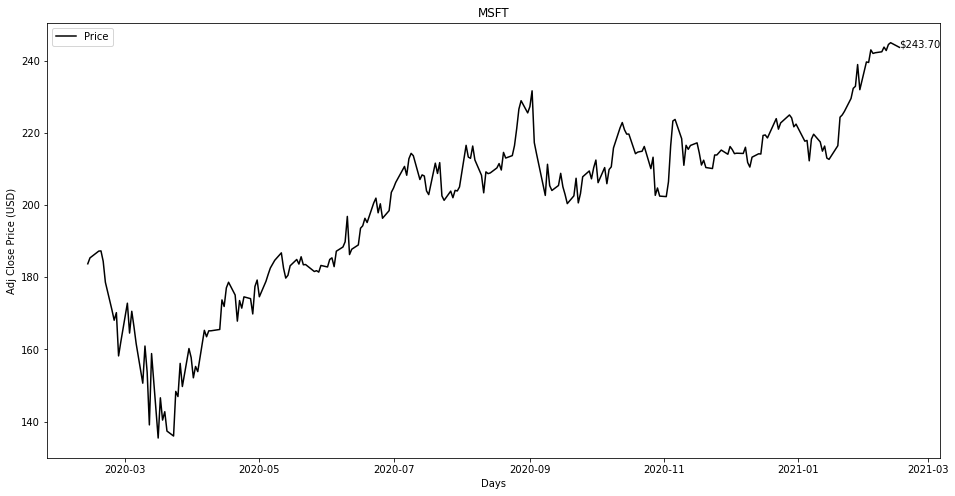

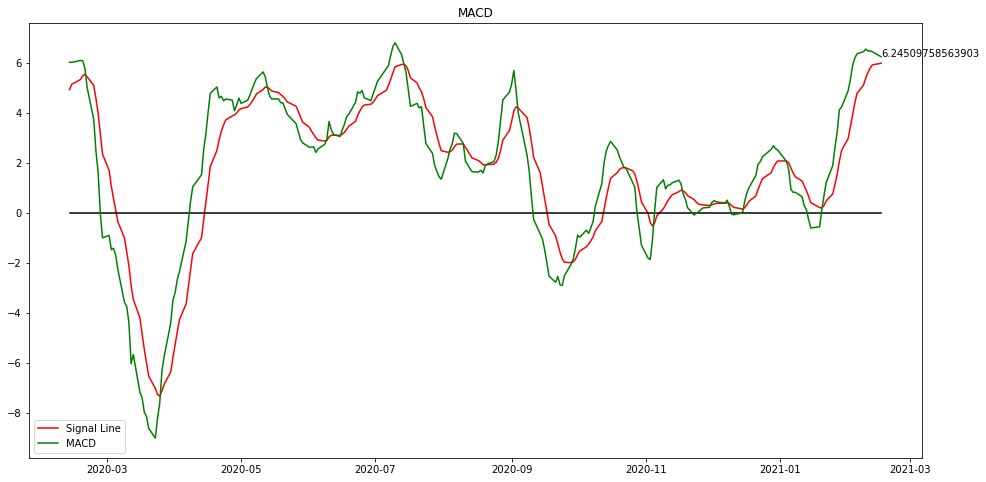

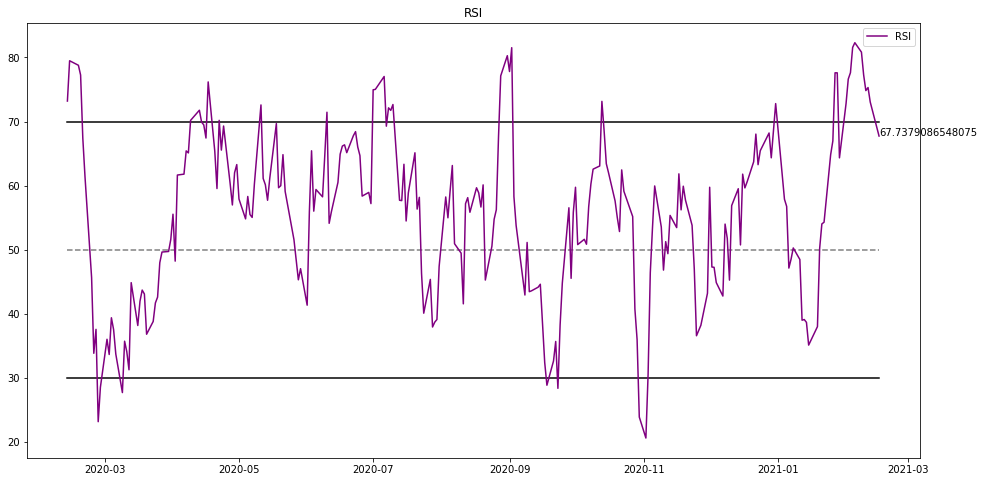

In [228]:
# Plot the graphs
plt.figure(figsize=(16,8))
plt.plot(df.index, df['Close'], color='black', label='Price')
plt.text(df.tail(1).index, df.tail(1)['Close'], "${:.2f}".format(df.tail(1)['Close'][0]))
plt.title(ticker)
plt.xlabel('Days')
plt.ylabel('Adj Close Price (USD)')
plt.legend()

plt.figure(figsize=(16,8))
plt.plot(df.index, df['Signal Line'], color='red', label='Signal Line')
plt.plot(df.index, [0 for i in df['MACD']], color='black')
plt.plot(df.index, df['MACD'], color='green', label='MACD')
plt.text(df.tail(1).index, df.tail(1)['MACD'], str(df.tail(1)['MACD'][0]))
plt.title('MACD')
plt.legend()

plt.figure(figsize=(16,8))
plt.plot(df.index, [30 for i in df['RSI']], color='black')
plt.plot(df.index, [50 for i in df['RSI']], color='grey', linestyle='--')
plt.plot(df.index, [70 for i in df['RSI']], color='black')
plt.plot(df.index, df['RSI'], color='purple', label='RSI')
plt.text(df.tail(1).index, df.tail(1)['RSI'], str(df.tail(1)['RSI'][0]))
plt.title('RSI')
plt.legend()